In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Consumer Discretionary 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services"
1411,1998-12-02,1171.25,223.410004,-5.686586,-11.716587,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1412,1998-12-03,1150.14,219.720001,-6.036617,-12.248891,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1413,1998-12-04,1176.74,223.520004,-4.892991,-11.819470,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1414,1998-12-07,1187.70,226.330002,-4.157454,-10.872647,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1415,1998-12-08,1181.38,227.729996,-7.134435,-12.696956,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1656.619995,4.852728,14.000423,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7195,2021-11-26,4594.62,1612.869995,1.616263,9.348602,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7196,2021-11-29,4655.27,1639.089966,1.484354,9.904247,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7197,2021-11-30,4567.00,1615.829956,1.396956,10.303088,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
145,2011,1,2011-01-13,1283.76,297.670013,-2.017265,-2.191622,UNDERPERFORM,221.898,111.401,160.853,171.257,115.980,118.609,157.121,3
146,2011,2,2011-02-10,1321.87,309.410004,-1.002060,-1.696583,UNDERPERFORM,223.046,111.753,161.153,171.896,117.043,118.591,157.484,3
147,2011,3,2011-03-10,1295.11,305.529999,-2.862136,-3.900228,UNDERPERFORM,224.093,112.122,165.001,176.398,116.668,118.497,157.714,3
148,2011,4,2011-04-14,1314.52,308.350006,2.688852,0.133144,UNDERPERFORM,224.806,112.552,165.908,177.507,116.068,118.882,157.791,3
149,2011,5,2011-05-12,1348.65,322.579987,0.838922,0.024802,UNDERPERFORM,224.806,112.922,165.322,177.014,116.423,119.279,158.602,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1462.900024,-2.530346,-0.461997,OUTPERFORM,273.092,120.078,187.663,186.335,151.745,123.413,185.530,3
272,2021,8,2021-08-12,4460.83,1448.939941,-1.849766,-4.989416,UNDERPERFORM,274.214,120.714,185.440,184.670,148.287,122.967,186.266,3
273,2021,9,2021-09-09,4493.28,1470.270020,-4.490556,-11.834229,UNDERPERFORM,276.590,122.650,183.194,182.511,147.534,124.886,186.661,3
274,2021,10,2021-10-14,4438.26,1476.890015,-7.366228,-8.690219,UNDERPERFORM,278.524,124.413,180.140,179.328,145.114,125.235,187.100,3


In [5]:
original = data[['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]

In [6]:
data.drop(columns=['date','S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
145,1,1283.76,297.670013,-2.017265,-2.191622,221.898,111.401,160.853,171.257,115.980,118.609,157.121,3
146,2,1321.87,309.410004,-1.002060,-1.696583,223.046,111.753,161.153,171.896,117.043,118.591,157.484,3
147,3,1295.11,305.529999,-2.862136,-3.900228,224.093,112.122,165.001,176.398,116.668,118.497,157.714,3
148,4,1314.52,308.350006,2.688852,0.133144,224.806,112.552,165.908,177.507,116.068,118.882,157.791,3
149,5,1348.65,322.579987,0.838922,0.024802,224.806,112.922,165.322,177.014,116.423,119.279,158.602,3


In [7]:
original['Performance'] = np.where(original['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]

In [8]:
dd.data_summary(original)

,Info
Rows,131
Columns,9
Size in Memory,10.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.40,0.49,2,79
month,int64,0,0,1,6,12,6.46,3.43,12,11
overall,float64,0,0,221.90,240.22,280.13,244.069,13.38,129,2
durables,float64,0,0,103.43,108.98,126.42,109.18,4.40,130,2
jewelry and watches,float64,0,0,158.21,169.21,187.66,169.68,6.23,130,2
jewelry,float64,0,0,161.80,175.75,186.34,174.59,5.65,131,1
watches,float64,0,0,114.93,129.56,153.74,130.78,10.91,131,1
sporting goods,float64,0,0,108.67,114.87,125.23,115.31,3.52,131,1
"pets, pet products and services",float64,0,0,157.12,169.86,188.69,170.49,7.60,131,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

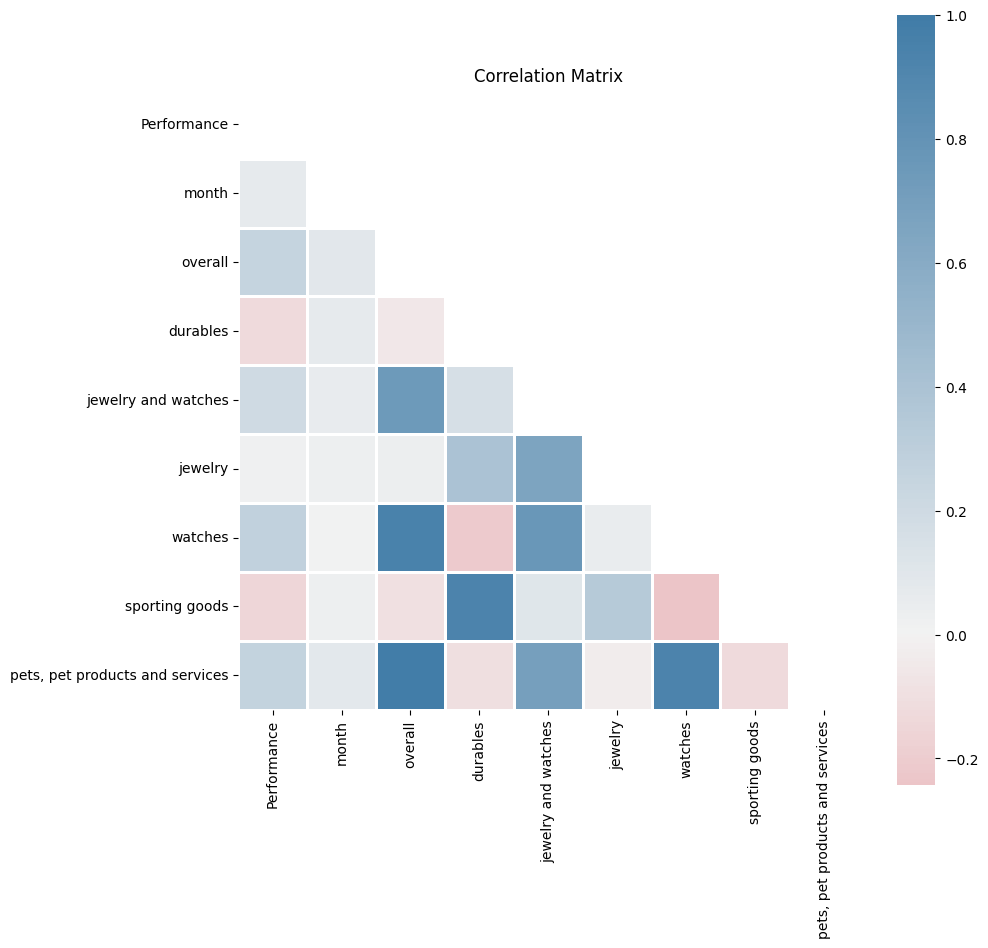

In [9]:
dd.correlation_matrix(original)

### Conditional GAN

In [10]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,2,1668.105017,371.809292,-2.648886,-2.458183,228.364368,109.724165,167.683337,169.755587,122.354228,118.089152,161.422109,3
1,10,3676.856133,1118.979450,-3.195069,-0.140356,261.848119,103.563553,169.789149,168.803777,141.110869,111.462931,166.255635,3
2,9,1701.257469,479.956225,-13.080476,-7.432049,237.819492,113.342404,173.004434,180.182438,122.509192,119.120814,165.607961,3
3,1,3661.822322,966.463634,-1.541460,-0.804033,242.503089,105.013760,165.653148,164.499360,142.290539,113.921737,179.809032,3
4,2,692.579054,111.059813,-6.932285,-2.304093,224.938859,112.724736,170.717127,185.040453,114.400221,117.381913,156.283637,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2309.581875,691.166176,-1.002833,-1.504855,253.976087,108.687476,160.229230,165.113075,126.174746,116.078354,167.307289,3
9996,4,1169.136817,482.960214,2.079406,-0.346590,236.287001,111.158118,163.671614,176.655125,118.738700,126.390536,163.358017,3
9997,3,3881.532192,1128.521366,8.817769,14.974833,260.365967,105.163226,188.033580,176.931622,144.860265,116.720468,182.378942,3
9998,6,3767.091725,689.746732,-5.055573,-2.050261,264.499145,103.707824,174.653920,181.216419,138.886100,112.514772,180.090862,3


In [11]:
samples['Performance'] = np.where(samples['S&P 500 Consumer Discretionary (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [12]:
samples = samples[['Performance','month', 'overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
samples.head()

,Performance,month,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services"
0,1,2,228.364368,109.724165,167.683337,169.755587,122.354228,118.089152,161.422109
1,1,10,261.848119,103.563553,169.789149,168.803777,141.110869,111.462931,166.255635
2,1,9,237.819492,113.342404,173.004434,180.182438,122.509192,119.120814,165.607961
3,1,1,242.503089,105.013760,165.653148,164.499360,142.290539,113.921737,179.809032
4,1,2,224.938859,112.724736,170.717127,185.040453,114.400221,117.381913,156.283637


In [13]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.66,0.48,2,6561
month,int64,0,0,1,6,12,6.44,3.42,12,924
overall,float64,0,0,215.10,239.81,292.44,243.90,14.048,10000,1
durables,float64,0,0,100.99,108.82,131.053,108.65,4.015,10000,1
jewelry and watches,float64,0,0,152.74,167.95,199.55,169.33,7.95,10000,1
jewelry,float64,0,0,159.93,177.15,190.70,176.15,5.78,9998,2
watches,float64,0,0,110.90,128.28,165.30,131.13,11.79,9999,2
sporting goods,float64,0,0,107.33,114.38,127.47,114.89,3.24,10000,1
"pets, pet products and services",float64,0,0,153.039,168.51,193.11,170.28,7.94,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

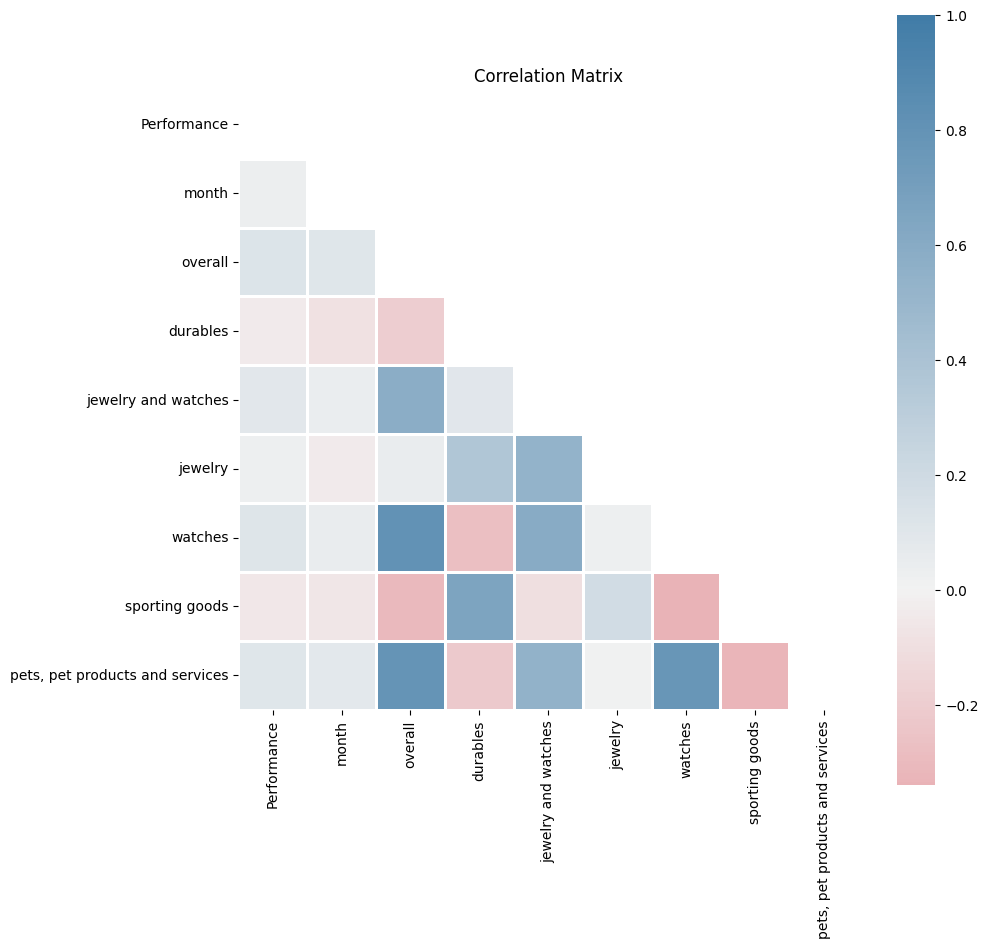

In [14]:
dd.correlation_matrix(samples)

In [15]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [16]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 6561, 0: 3439})
Counter({1: 6561, 0: 6561})


### Interaction Terms

In [17]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  228.36436797,   109.72416526,   167.68333748, ...,
        14448.70699246, 19750.67756471, 19062.19989159],
       [  261.84811854,   103.56355338,   169.78914899, ...,
        15728.63096272, 23460.47702071, 18531.34024212],
       [  237.81949159,   113.34240421,   173.0044343 , ...,
        14593.39468155, 20288.49746012, 19727.35505849],
       ...,
       [  237.25075918,   109.89296132,   159.72730796, ...,
        14009.69271265, 20324.60427136, 19063.20688272],
       [  256.82627098,   104.11589707,   173.2316972 , ...,
        16380.80181219, 26421.73958173, 19645.25301197],
       [  262.64791267,   105.82410749,   190.54485381, ...,
        16951.9165932 , 26777.41216061, 20983.58661796]])

In [18]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(13122, 29)

In [19]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(131, 29)

In [20]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [21]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.665988,0.724849,0.549763,0.623372,0.640963,0.6888,0.521818,0.593793,0.503817,0.405797,0.538462,0.46281
1,DecisionTreeClassifier,0.645412,0.662006,0.608444,0.632779,0.623286,0.635827,0.587273,0.610586,0.465649,0.378378,0.538462,0.444444
2,RandomForestClassifier,0.745779,0.785165,0.698823,0.735883,0.715635,0.739159,0.671515,0.703715,0.48855,0.417582,0.730769,0.531469
3,AdaBoostClassifier,0.591908,0.601178,0.547479,0.57285,0.574215,0.585185,0.526667,0.554386,0.541985,0.441176,0.576923,0.5
4,GradientBoostingClassifier,0.61096,0.625485,0.55555,0.588041,0.593721,0.609841,0.533333,0.569027,0.557252,0.45,0.519231,0.482143
5,ExtraTreesClassifier,0.780073,0.819258,0.740432,0.773952,0.739409,0.756617,0.710303,0.732729,0.534351,0.452632,0.826923,0.585034
6,BaggingClassifier,0.679324,0.741021,0.565768,0.639693,0.671442,0.722395,0.56303,0.632834,0.526718,0.424242,0.538462,0.474576
7,SVC,0.592365,0.622279,0.470962,0.535844,0.595245,0.635522,0.457576,0.532065,0.587786,0.480769,0.480769,0.480769
8,GaussianNB,0.567595,0.604169,0.392164,0.475554,0.560195,0.600388,0.375152,0.461768,0.603053,0.5,0.403846,0.446809


### Voting Classifier

In [22]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.731484,0.748867,0.701212,0.724257


## Using all data

In [23]:
data = pd.read_csv('../data/S&P 500 Consumer Discretionary 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,1998,12,1998-12-10,1165.02,225.119995,-7.051962,-12.240759,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600,3
1,1999,1,1999-01-14,1212.19,241.960007,-7.478419,-10.517747,UNDERPERFORM,164.700,126.200,141.300,146.200,124.700,121.200,102.500,3
2,1999,2,1999-02-11,1254.04,253.789993,-7.793888,-10.542833,UNDERPERFORM,164.800,125.900,140.200,144.200,123.700,121.500,102.800,3
3,1999,3,1999-03-11,1297.68,270.940002,-2.451345,1.187628,OUTPERFORM,165.900,125.900,142.000,147.300,123.100,121.400,103.400,3
4,1999,4,1999-04-08,1343.98,282.480011,0.084895,5.845326,OUTPERFORM,166.000,125.700,142.500,148.000,123.100,121.000,103.600,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1462.900024,-2.530346,-0.461997,OUTPERFORM,273.092,120.078,187.663,186.335,151.745,123.413,185.530,3
272,2021,8,2021-08-12,4460.83,1448.939941,-1.849766,-4.989416,UNDERPERFORM,274.214,120.714,185.440,184.670,148.287,122.967,186.266,3
273,2021,9,2021-09-09,4493.28,1470.270020,-4.490556,-11.834229,UNDERPERFORM,276.590,122.650,183.194,182.511,147.534,124.886,186.661,3
274,2021,10,2021-10-14,4438.26,1476.890015,-7.366228,-8.690219,UNDERPERFORM,278.524,124.413,180.140,179.328,145.114,125.235,187.100,3


In [24]:
original = data[['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
data.drop(columns=['date','S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,10,1913.469960,615.332662,-7.908805,-6.728053,234.982802,104.122482,163.284320,175.339567,119.672257,111.228459,172.629979,3
1,1,1249.064206,240.811454,3.544951,4.544701,201.069488,112.331323,165.950764,158.444054,117.292988,118.515029,162.304793,3
2,7,1299.290789,260.601427,3.744611,2.171088,177.458142,125.969114,137.397858,136.840821,113.939178,116.815461,114.589824,3
3,6,2904.301254,923.648886,-5.358551,-1.601555,255.514439,112.900885,171.813250,177.874944,138.812756,121.028769,174.087003,3
4,10,1364.497221,577.137213,-3.355008,-6.902400,225.456171,113.030420,167.917151,178.594468,118.583091,118.237451,173.419540,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,2568.073495,1424.662538,-2.459550,9.958976,274.589241,107.876865,178.139866,170.037228,131.857335,108.566549,195.167595,3
9996,10,909.544690,206.911115,-9.260760,-11.634169,184.024699,123.988294,130.055347,134.362670,118.008539,113.329605,122.435005,3
9997,4,1109.602140,287.780962,0.906947,-3.566447,210.963669,114.022068,149.308939,135.533566,112.034500,115.076269,108.969223,3
9998,2,1067.654400,222.423983,-2.835711,-2.915419,201.026550,111.041026,139.709834,151.458879,114.173853,117.583298,162.848950,3


In [25]:
samples['Performance'] = np.where(samples['S&P 500 Consumer Discretionary (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.644508,0.62914,0.69962,0.661647,0.640415,0.627673,0.689703,0.657228,0.518116,0.4375,0.411765,0.424242
1,DecisionTreeClassifier,0.619288,0.611139,0.647804,0.627123,0.609672,0.603798,0.63718,0.62004,0.474638,0.4,0.436975,0.417671
2,RandomForestClassifier,0.709549,0.708837,0.705681,0.704422,0.681865,0.683659,0.676572,0.680097,0.557971,0.478873,0.285714,0.357895
3,AdaBoostClassifier,0.63785,0.644724,0.613928,0.628764,0.64525,0.654185,0.615757,0.634389,0.561594,0.488372,0.352941,0.409756
4,GradientBoostingClassifier,0.647869,0.655853,0.621876,0.638207,0.659413,0.668125,0.633034,0.650106,0.547101,0.464286,0.327731,0.384236
5,ExtraTreesClassifier,0.720435,0.716655,0.72227,0.715739,0.690155,0.690443,0.689012,0.689727,0.528986,0.41791,0.235294,0.301075
6,BaggingClassifier,0.667833,0.685712,0.611364,0.643282,0.645596,0.665879,0.583967,0.622239,0.554348,0.469697,0.260504,0.335135
7,SVC,0.636036,0.640667,0.61945,0.629739,0.645596,0.652205,0.623359,0.637456,0.572464,0.505155,0.411765,0.453704
8,GaussianNB,0.602436,0.595453,0.639487,0.616482,0.61209,0.607427,0.633034,0.619966,0.561594,0.492537,0.554622,0.521739
